# Measure properties of M1-67 globules from HST H alpha images

## Install and import packages

These packages are not in the default colab environment, so we must install them with pip.

In [1]:
!pip install astroquery regions cmasher --quiet

In [2]:
from astroquery.mast import Observations
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
import regions

from matplotlib import pyplot as plt
import seaborn as sn
sn.set_context("notebook")
import cmasher as cm

## Download data from MAST archive

Get a list of all the dtatsets that have been processed by the Hubble Legacy Archive and that use the Ha filter.

*Note that the older instruments like WFPC2 are not available from Amazon AWS, so we need to get the data directly from the archive.*

In [3]:
table = Observations.query_criteria(
    objectname="WR124", 
    radius="1 arcmin",
    filters=["F656N"],
    project="HLA",
    )
table.remove_column("s_region")

In [4]:
table

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance
str5,int64,str3,str39,str10,float64,float64,float64,float64,float64,str7,str17,float64,float64,str1,str1,float64,str9,str6,str5,str3,str3,int64,str3,str175,str176,str6,bool,float64,str7,str8,str8,str8,float64
image,3,HLA,hst_06787_01_wfpc2_f656n_pc,PK050+03D1,287.8680820163602,16.861139634877297,50523.49219,50523.77734,10216.0,OPTICAL,F656N,655299987792.9688,657460021972.6562,--,--,50889.27368054,WFPC2/PC,MOFFAT,6787,HLA,HLA,--,HLA,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_06787_01_wfpc2_f656n_pc,https://hla.stsci.edu/cgi-bin/getdata.cgi?dataset=hst_06787_01_wfpc2_f656n_pc_drz.fits,PUBLIC,--,nan,science,25602505,67526819,67526819,10.693224856847792
image,3,HLA,hst_06787_01_wfpc2_f656n_wf,PK050+03D1,287.87476345420487,16.86723413060137,50523.49219,50523.77734,10216.0,OPTICAL,F656N,655299987792.9688,657460021972.6562,--,--,50889.27368054,WFPC2/WFC,MOFFAT,6787,HLA,HLA,--,HLA,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_06787_01_wfpc2_f656n_wf,https://hla.stsci.edu/cgi-bin/getdata.cgi?dataset=hst_06787_01_wfpc2_f656n_wf_drz.fits,PUBLIC,--,517.0,science,25602506,67526820,67526820,0.0
image,3,HLA,hst_11137_01_wfpc2_f656n_pc,WR124,287.87609821697606,16.85152248850094,54638.65367,54638.75043,4200.0,OPTICAL,F656N,655299987792.9688,657460021972.6562,--,--,55003.87702537,WFPC2/PC,MOFFAT,11137,HLA,HLA,--,HLA,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_11137_01_wfpc2_f656n_pc,https://hla.stsci.edu/cgi-bin/getdata.cgi?dataset=hst_11137_01_wfpc2_f656n_pc_drz.fits,PUBLIC,--,nan,science,25724916,67649230,67649230,10.244428750365518
image,3,HLA,hst_11137_01_wfpc2_f656n_wf,WR124,287.8809628974585,16.85790240304982,54638.65367,54638.75043,4200.0,OPTICAL,F656N,655299987792.9688,657460021972.6562,--,--,55003.87702537,WFPC2/WFC,MOFFAT,11137,HLA,HLA,--,HLA,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_11137_01_wfpc2_f656n_wf,https://hla.stsci.edu/cgi-bin/getdata.cgi?dataset=hst_11137_01_wfpc2_f656n_wf_drz.fits,PUBLIC,--,5279.0,science,25724917,67649231,67649231,0.0
IMAGE,3,HLA,hst_06787_01_wfpc2_f675w_f656n_f555w_pc,PK050+03D1,287.8680725097656,16.861112594604492,nan,nan,10456.4599609375,OPTICAL,F675W;F656N;F555W,nan,nan,--,--,50888.57870358,WFPC2/PC,MOFFAT,6787,HLA,HLA,--,HLA,http://hla.stsci.edu/cgi-bin/fitscut.cgi?red=hst_06787_01_wfpc2_f675w_pc&amp;green=hst_06787_01_wfpc2_f656n_pc&amp;blue=hst_06787_01_wfpc2_f555w_pc&amp;size=ALL&amp;format=jpg,http://hla.stsci.edu/cgi-bin/fitscut.cgi?red=hst_06787_01_wfpc2_f675w_pc&amp;green=hst_06787_01_wfpc2_f656n_pc&amp;blue=hst_06787_01_wfpc2_f555w_pc&amp;size=ALL&amp;format=fits,PUBLIC,--,nan,science,26152133,68226608,68226608,10.693224856847792
IMAGE,3,HLA,hst_06787_01_wfpc2_f675w_f656n_f555w_wf,PK050+03D1,287.8815612792969,16.86099624633789,nan,nan,10456.4599609375,OPTICAL,F675W;F656N;F555W,nan,nan,--,--,50888.57870358,WFPC2/WFC,MOFFAT,6787,HLA,HLA,--,HLA,http://hla.stsci.edu/cgi-bin/fitscut.cgi?red=hst_06787_01_wfpc2_f675w_wf&amp;green=hst_06787_01_wfpc2_f656n_wf&amp;blue=hst_06787_01_wfpc2_f555w_wf&amp;size=ALL&amp;format=jpg,http://hla.stsci.edu/cgi-bin/fitscut.cgi?red=hst_06787_01_wfpc2_f675w_wf&amp;green=hst_06787_01_wfpc2_f656n_wf&amp;blue=hst_06787_01_wfpc2_f555w_wf&amp;size=ALL&amp;format=fits,PUBLIC,--,nan,science,26152134,68226609,68226609,0.0


To start with, we will just use the WFC image from the second epoch 

In [5]:
products = Observations.get_product_list(table)

And we only want the final drizzled images

In [6]:
filtered = Observations.filter_products(products,
                                        obs_id="hst_11137_01_wfpc2_f656n_wf",
                                        productSubGroupDescription='DRZ')

In [7]:
filtered

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str39,str67,str1,str168,str9,str28,str7,str1,str8,str19,str5,str48,int64,str8,str6,int64
25724917,HLA,image,hst_11137_01_wfpc2_f656n_wf,HLA simple fits science image,C,mast:HLA/url/cgi-bin/getdata.cgi?dataset=hst_11137_01_wfpc2_f656n_wf_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,HLA,--,11137,hst_11137_01_wfpc2_f656n_wf_drz.fits,55607040,25724917,PUBLIC,3


The first file is the one we want:

In [8]:
manifest = Observations.download_products(filtered[0], productType="SCIENCE")

INFO:astroquery:Found cached file ./mastDownload/HLA/hst_11137_01_wfpc2_f656n_wf/hst_11137_01_wfpc2_f656n_wf_drz.fits with expected size 55607040.


INFO: Found cached file ./mastDownload/HLA/hst_11137_01_wfpc2_f656n_wf/hst_11137_01_wfpc2_f656n_wf_drz.fits with expected size 55607040. [astroquery.query]


In [9]:
manifest

Local Path,Status,Message,URL
str83,str8,object,object
./mastDownload/HLA/hst_11137_01_wfpc2_f656n_wf/hst_11137_01_wfpc2_f656n_wf_drz.fits,COMPLETE,None,None


In [10]:
fn = manifest[0]["Local Path"]

In [11]:
hdulist = fits.open(fn)
hdulist.info()

Filename: ./mastDownload/HLA/hst_11137_01_wfpc2_f656n_wf/hst_11137_01_wfpc2_f656n_wf_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1194   ()      
  1  SCI           1 ImageHDU       103   (2150, 2150)   float32   
  2  WHT           1 ImageHDU       124   (2150, 2150)   float32   
  3  CTX           1 ImageHDU       123   (2150, 2150)   int32   


## Plot image of data

In [12]:
hdu = hdulist['SCI']
wcs = WCS(hdu)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 287.8782164216667  16.86331641638889  
CRPIX : 1075.0  1075.0  
CD1_1 CD1_2  : -2.777777777777778e-05  0.0  
CD2_1 CD2_2  : 0.0  2.777777777777778e-05  
NAXIS : 2150  2150

In [13]:
import numpy as np
from astropy.visualization import simple_norm
from astropy.coordinates import SkyCoord

Get celestial coordinates of central WR star

In [14]:
c0 = SkyCoord.from_name('wr124', cache=True)
c0

<SkyCoord (ICRS): (ra, dec) in deg
    (287.87864549, 16.86061137)>

Convert to pixel coordinates and define the size of the window we want to plot (in pixels, which are  0.1 arcsec)

In [15]:
x0, y0 = wcs.world_to_pixel(c0)
mx, my = 600, 600

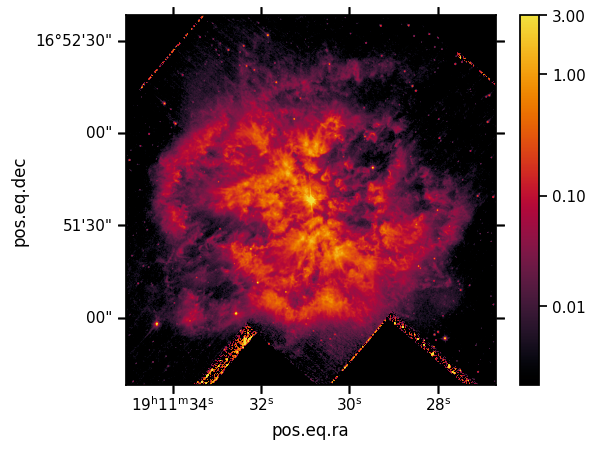

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection=wcs)
norm = simple_norm(hdu.data, stretch='log', min_cut=0, max_cut=3)
im = ax.imshow(hdu.data, norm=norm, cmap=cm.ember)
cb = fig.colorbar(im, ax=ax, ticks=[0.01, 0.1, 1.0, 3.0])
ax.set(
    xlim=[x0 - mx, x0 + mx],
    ylim=[y0 - my, y0 + my],
)
...;

## Plot brightness versus radius

Get the angular separation of each image pixel from the central star

In [17]:
ny, nx = hdu.data.shape
xpix, ypix = np.meshgrid(np.arange(nx), np.arange(ny))
pixcoords = wcs.pixel_to_world(xpix, ypix)
seps = c0.separation(pixcoords)
seps.arcsec.min(), seps.arcsec.max()

(0.04392998540547969, 160.06571401566916)

In [18]:
goodpixels = hdu.data > 0.0
radius = seps.arcsec[goodpixels]
brightness = hdu.data[goodpixels]

In [19]:
brightness.min(), brightness.max()

(1.3422259e-08, 4471.7876)

Make a histogram of the radius and brightness on a log scale.

In [20]:
rmin, rmax = 0.5, 1.02 * radius.max()
bmin, bmax = 0.001, 5.0
ymin, ymax = np.log10(bmin), np.log10(bmax)
xmin, xmax = np.log10(rmin), np.log10(rmax)
H, yedges, xedges = np.histogram2d(
    np.log10(brightness),
    np.log10(radius),
    bins=300,
    range=[[ymin, ymax], [xmin, xmax]],
    weights=brightness,
    density=True,
)
H.sum() * (ymax - ymin) * (xmax - xmin) / np.product(H.shape)


1.0

In [21]:
HH = np.where(H == 0.0, np.nan, H)

In [22]:
from matplotlib.colors import PowerNorm

And plot the histogram.

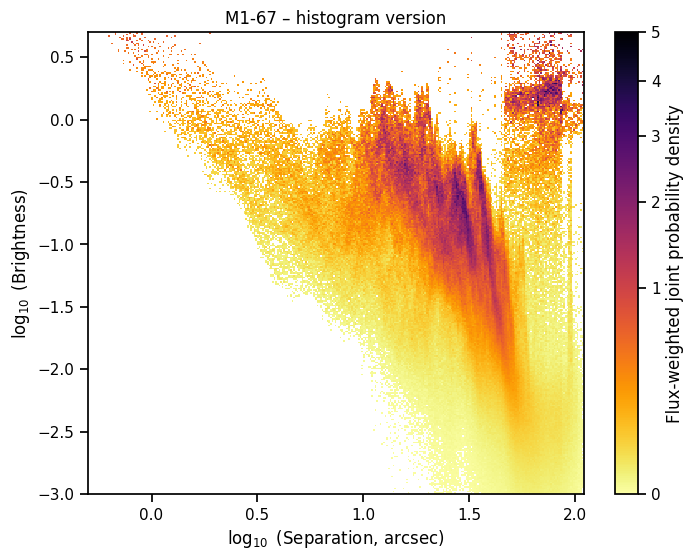

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    HH, 
    origin="lower", 
    norm=PowerNorm(gamma=0.5, vmin=0.0, vmax=5),
    cmap="inferno_r", 
    extent=[xmin, xmax, ymin, ymax], 
    aspect="auto",
    interpolation="none",
)

fig.colorbar(im, ax=ax, label="Flux-weighted joint probability density")
ax.set(
    xlabel=r'$\log_{10}$ (Separation, arcsec)',
    ylabel=r'$\log_{10}$ (Brightness)',
    title=f"M1-67 – histogram version",
)
...;

Note that we have a bunch of spurious bright pixels for radii > 45

In [24]:
badpix = (radius > 45.0) & (brightness > 0.3)
brightness[badpix] = np.nan

Now do the same but with a linear radius scale and a sqrt brightness scale. 

In [52]:
rmin, rmax = 0.0, 70.0
bmin, bmax = 0.0, 4.0
ymin, ymax = np.sqrt(bmin), np.sqrt(bmax)
xmin, xmax = rmin, rmax
H, yedges, xedges = np.histogram2d(
    np.sqrt(brightness),
    radius,
    bins=(100, 200),
    range=[[ymin, ymax], [xmin, xmax]],
    weights=brightness,
    density=True,
)
H.sum() * (ymax - ymin) * (xmax - xmin) / np.product(H.shape)


1.0

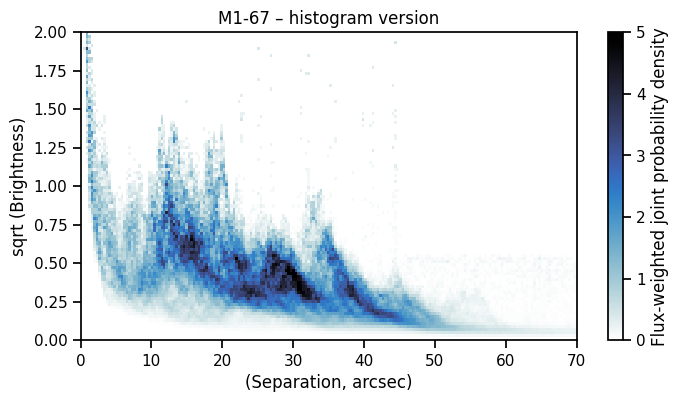

In [53]:
HH = np.where(H == 0.0, np.nan, H)
HH /= np.nansum(HH) / np.isfinite(HH).sum()
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(
    HH, 
    origin="lower", 
    norm=PowerNorm(gamma=1.0, vmin=0.0, vmax=5.0),
    cmap=cm.arctic_r,
    extent=[xmin, xmax, ymin, ymax], 
    aspect="auto",
    interpolation="none",
)

fig.colorbar(im, ax=ax, label="Flux-weighted joint probability density")
ax.set(
    xlabel=r'(Separation, arcsec)',
    ylabel=r'sqrt (Brightness)',
    title=f"M1-67 – histogram version",
)
...;

In [54]:
fig.savefig("m1-67-global-brightness-profile.pdf", bbox_inches='tight')

This shows the structure much better. We see the multiple shells in the nebula. The color is proportional to the fraction of the total nebular emission that comes from that cobination of suface brightness and radius. This tends to be maximum for the median brightness, but the peak brightnesses are also a significant fraction (but never a majority)
                                            

## Look at the globules

Get the region file from the Github repo of the Roberto seminario project:

In [28]:
region_url = (
    "https://raw.githubusercontent.com/"
    "will-henney/globule-seminario/"
    "main/m1-67/m1-67-globules.reg"
    )

Select only those regions that are circle points, since those are the ones that are the globules.

In [29]:
regs = regions.Regions.read(region_url, format="ds9")
regs = [_ for _ in regs if hasattr(_, 'center') and _.visual.get('marker') == "o"]

In [30]:
len(regs)

169

That is the correct number that I had counted before. 

Now look at the visual properties of the regions:

In [31]:
regs[0].visual

{'color': 'green',
 'default_style': 'ds9',
 'marker': 'o',
 'fontname': 'helvetica',
 'fontsize': 10,
 'fontweight': 'normal',
 'fontstyle': 'normal',
 'markeredgewidth': 3}

Select those with thicker borders, which are the ones I judged to be well isolated

In [32]:
rregs = [_ for _ in regs if _.visual.get('markeredgewidth') == 3]
len(rregs)

49

Make a table of the globule sources.

*Aside: is "globule" a good term?  In the Helix, we have "cometary knots". There are "cometary globules" around H II regions, but those are larger. Then there is Gaum's term of "globulettes" for the smaller versions, such as in the Rosette.*

In [33]:
from astropy.table import QTable, Table

In [34]:
source_table = QTable(
    [
        {"ICRS": r.center, "Isolated": r.visual.get('markeredgewidth') == 3} 
        for r in regs
    ]
)

Add columns for position angle and separation from star. Unlike the previous case with the proplyds, we want the PA of the globule wrt to the star, not the other way around. 

In [35]:
source_table["PA"] = c0.position_angle(source_table["ICRS"]).to(u.deg)
source_table["Sep"] = source_table["ICRS"].separation(c0).to(u.arcsec)
source_table["PA"].info.format = ".2f"
source_table["Sep"].info.format = ".2f"

In [36]:
source_table.show_in_notebook()

idx,ICRS,Isolated,PA,Sep
,"deg,deg",,deg,arcsec
0,"287.8779225,16.858874166666666",True,201.82,6.76
1,"287.87682416666667,16.860386666666667",True,262.48,6.35
2,"287.87825624999994,16.85882777777778",True,191.94,6.59
3,"287.87846541666664,16.85866027777778",True,185.20,7.07
4,"287.87877166666664,16.858544166666668",True,176.83,7.48
5,"287.8772941666666,16.858095277777778",True,207.25,10.21
6,"287.87750291666663,16.857993055555557",True,202.73,10.24
7,"287.87696874999995,16.858633055555558",True,219.06,9.20
8,"287.87678416666665,16.859988055555558",True,250.60,6.82


### Spatial distribution of globules

Plot the spatial distribution of the globules on PA, separation plane. 

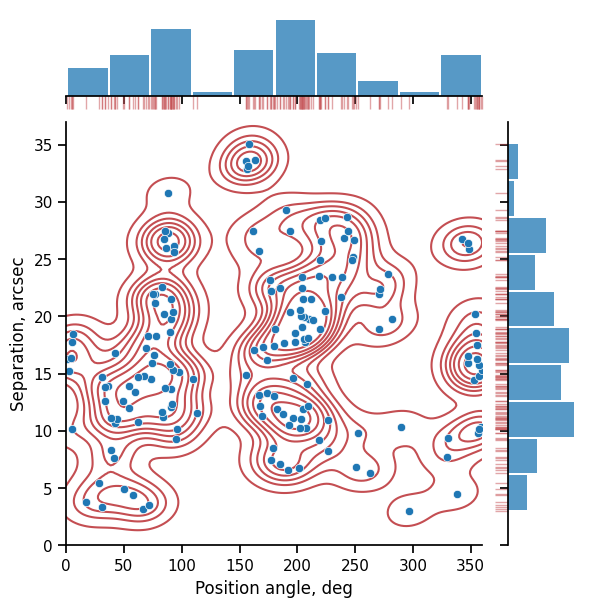

In [37]:
sn.set_color_codes()
g = sn.jointplot(
    x=source_table['PA'].value, 
    y=source_table['Sep'].value,
    height=6, space=0.3, ratio=4,
    marginal_kws={'shrink': 0.95, 'lw': 0, 'bins': 10},
    )
g.plot_joint(sn.kdeplot, bw_adjust=0.4, color="r", zorder=0, levels=9)
g.plot_marginals(sn.rugplot, color="r", alpha=0.5, height=-.15, clip_on=False)
g.figure.axes[0].set(
    xlim=[0, 360],
    ylim=[0, 37],
    xlabel='Position angle, deg',
    ylabel='Separation, arcsec',
)
g.figure.axes[1].set(ylim=[0, 40])
g.figure.axes[2].set(xlim=[0, 40])

...;

In [51]:
g.figure.savefig('m1-67-globules-pa-sep-jointplot.pdf', bbox_inches='tight')

### Brightness profile of individual globules

First we will make an image cutout

In [39]:
source = source_table[0]
source

ICRS,Isolated,PA,Sep
"deg,deg",,deg,arcsec
SkyCoord,bool,float64,float64
"287.8779225,16.858874166666666",True,201.82,6.76


In [40]:
j1, i1 = wcs.world_to_array_index(source['ICRS'])
size = 15
yslice, xslice = slice(j1 - size, j1 + size), slice(i1 - size, i1 + size)
cutout = hdu.data[yslice, xslice]
wcutout = wcs.slice((yslice, xslice))
wcutout

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 287.8782164216667  16.86331641638889  
CRPIX : 6.0  176.0  
CD1_1 CD1_2  : -2.777777777777778e-05  0.0  
CD2_1 CD2_2  : 0.0  2.777777777777778e-05  
NAXIS : 30  30

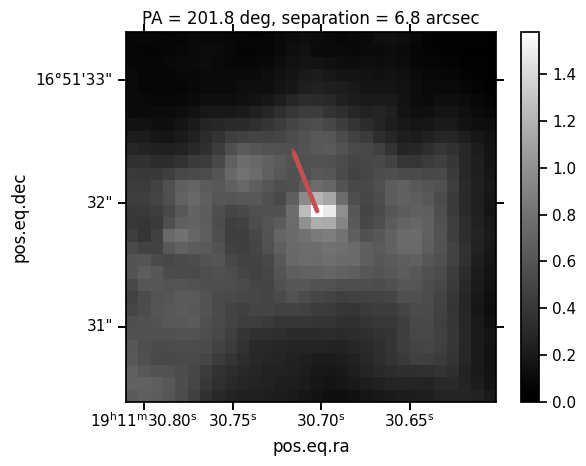

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection=wcutout)
im = ax.imshow(cutout, vmin=0.0, cmap=cm.neutral)
cb = fig.colorbar(im, ax=ax)
x1, y1 = wcutout.world_to_array_index(source['ICRS'])
arrow_length = 5.0
dx, dy = arrow_length * np.sin(source['PA']), -arrow_length * np.cos(source['PA'])
ax.arrow(x1, y1, dx, dy, color='r', lw=3)
ax.set_title(f"PA = {source['PA']:.1f}, separation = {source['Sep']:.1f}")
...;

That worked, but we can simplify things by using astropy.nddata.Cutout2D(). The following class is based on what I did for the Julia+Tom proplyd project, but modified for our needs

In [42]:
from astropy.nddata import Cutout2D
from astropy.coordinates import Angle

class SourceCutout:
    
    def __init__(self, pdata, hdu, size=3 * u.arcsec):
        self.center = pdata["ICRS"]
        # PA of source wrt star
        self.pa_source = pdata["PA"]
        # and PA of star wrt source
        self.pa_star = Angle(self.pa_source + 180 * u.deg).wrap_at(360 * u.deg)
        self.sep = pdata["Sep"]
        self.size = size
        self.cutout = Cutout2D(
            hdu.data, position=self.center, size=size, wcs=WCS(hdu), copy=True,
        )
        self.image = self.cutout.data
        self.wcs = self.cutout.wcs
        ny, nx = self.image.shape
        self.image_coords = self.wcs.pixel_to_world(
            *np.meshgrid(np.arange(nx), np.arange(ny))
        )
        # Radius and PA of each pixel with respect to the center
        self.r = self.center.separation(self.image_coords)
        self.pa = self.center.position_angle(self.image_coords)
        # Default mask has max radius of half the cutout size
        self.set_mask(r_out=self.size / 2)
        
    def __repr__(self):
        return f"SourceCutout({self.pa_source:.1f}, {self.sep:.1f})"
       
         
    def set_mask(
        self,
        r_out = 1.0 * u.arcsec,
        r_in = 0.2 * u.arcsec,
        mu_min = 0.5,
    ):
        cth = np.cos((self.pa - self.pa_star))
        self.mask = (self.r <= r_out) & ((cth >= mu_min) | (self.r <= r_in))

In [43]:
source = source_table[45]
cutout = SourceCutout(source, hdu)

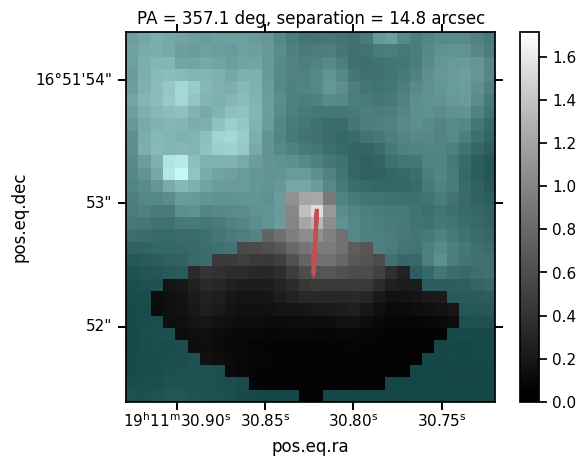

In [44]:
fig = plt.figure()
ax = fig.add_subplot(projection=cutout.wcs)
im = ax.imshow(
    cutout.image,
    vmin=0.0, 
    cmap=cm.neutral,
    )
cb = fig.colorbar(im, ax=ax)
ax.imshow(np.where(cutout.mask, np.nan, 1.0), vmin=0, vmax=1, cmap=cm.gem, alpha=0.3)
y1, x1 = cutout.wcs.world_to_array_index(cutout.center)
arrow_length = 5.0
dx, dy = -arrow_length * np.sin(cutout.pa_star), arrow_length * np.cos(cutout.pa_star)
ax.arrow(x1, y1, dx, dy, color='r', lw=3)
ax.set_title(f"PA = {cutout.pa_source:.1f}, separation = {cutout.sep:.1f}")
...;

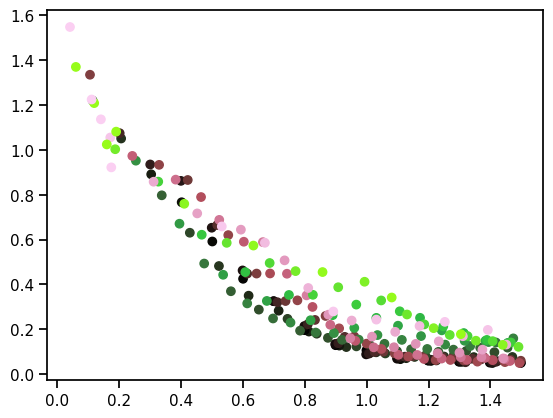

In [45]:
fig, ax = plt.subplots()
m = cutout.mask
ax.scatter(
    cutout.r[m].arcsec, 
    cutout.image[m], 
    c=Angle(cutout.pa - cutout.pa_star).wrap_at(180*u.deg).deg[m], 
    vmin=-60, vmax=60,
    cmap=cm.watermelon)

In [46]:
cutouts = [SourceCutout(source, hdu) for source in source_table if source['Isolated']]
cutouts = sorted(cutouts, key=lambda x: x.sep.value)

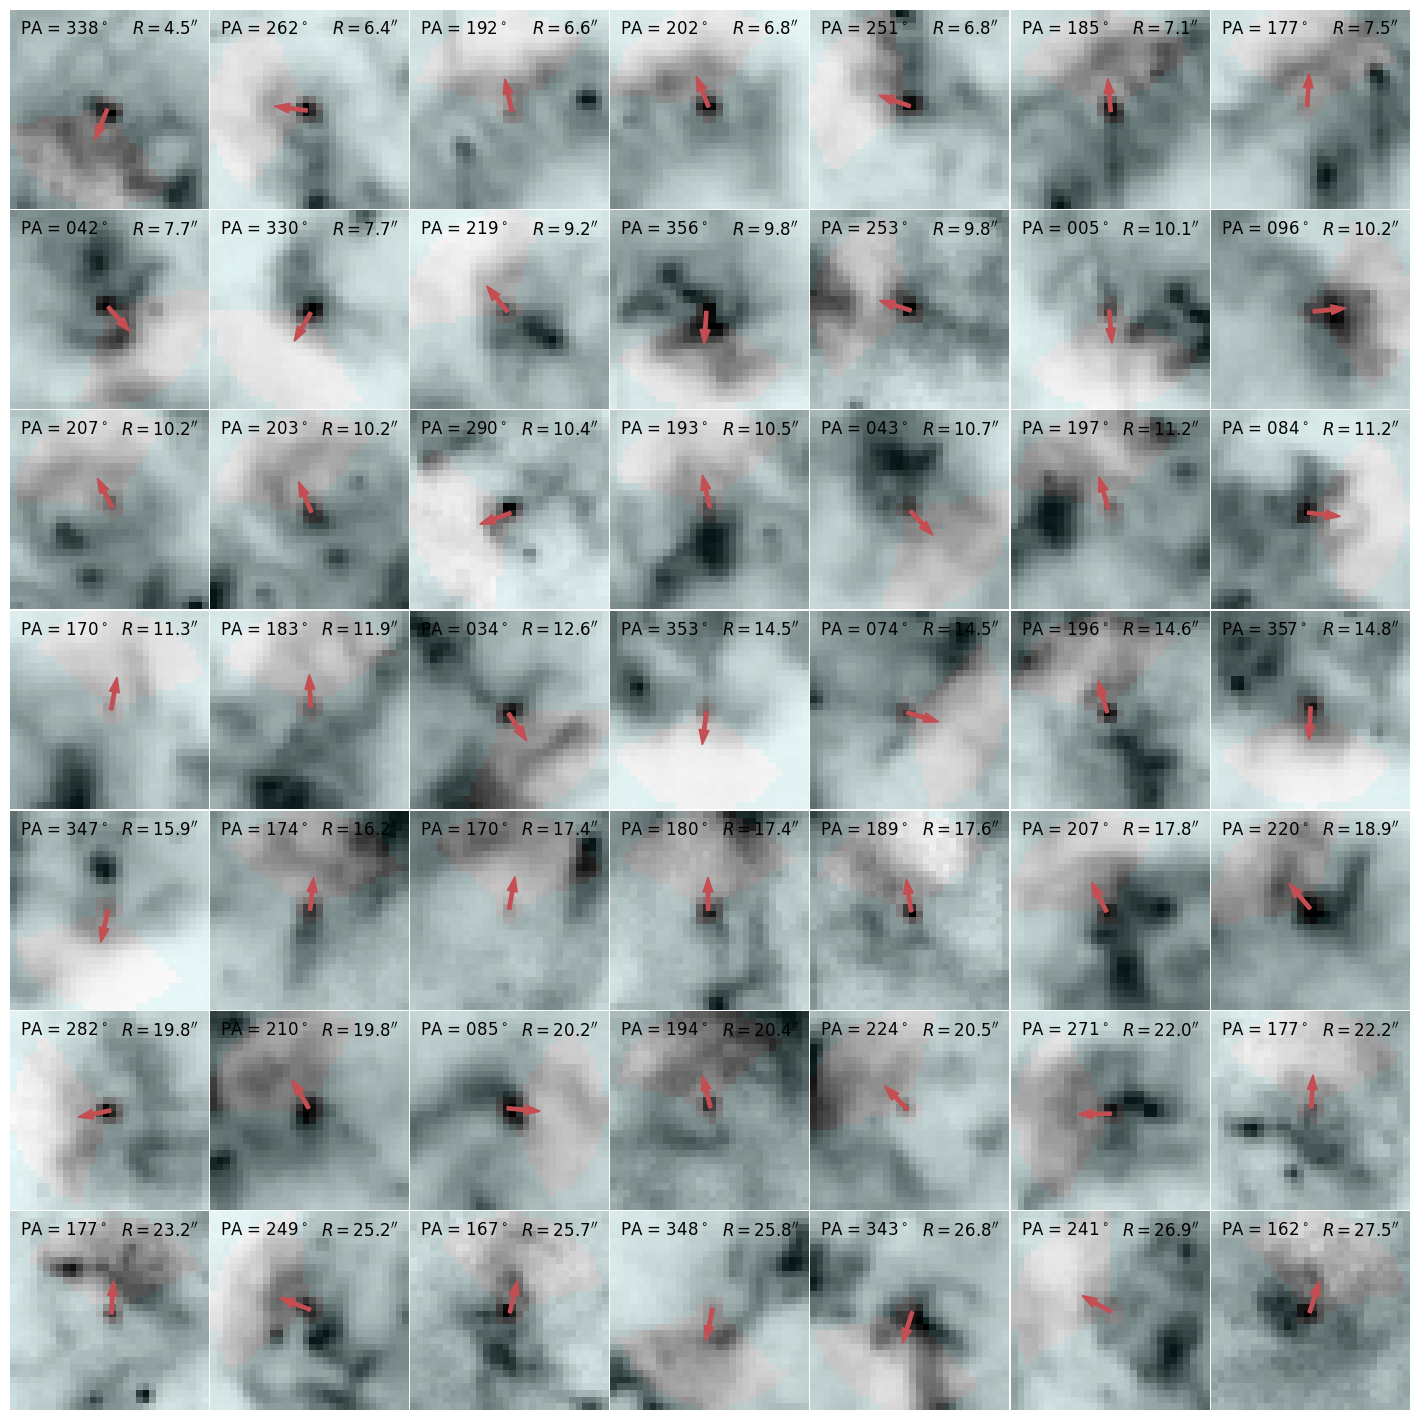

In [47]:
fig = plt.figure(figsize=(14, 14))
for idx, cutout in enumerate(cutouts):
    ax = fig.add_subplot(7, 7, idx + 1)
    im = ax.imshow(cutout.image, vmin=0.0,  cmap=cm.neutral_r, origin='lower')
    ax.imshow(np.where(cutout.mask, np.nan, 1.0), vmin=0, vmax=1, cmap=cm.gem, alpha=0.1, origin='lower')
    x1, y1 = cutout.wcs.world_to_pixel(cutout.center)
    arrow_length = 5.0
    dx, dy = -arrow_length * np.sin(cutout.pa_star), arrow_length * np.cos(cutout.pa_star)
    ax.arrow(x1, y1, dx, dy, color='r', width=0.5, head_width=1.5, length_includes_head=True, )
    ax.text(0.05, 0.95, rf'PA = {round(cutout.pa_source.value):03d}$^\circ$', transform=ax.transAxes, va="top", ha="left")
    ax.text(0.95, 0.95, rf"$R = {cutout.sep.value:.1f}''$", transform=ax.transAxes, va="top", ha="right")

    ax.set(xlabel="", ylabel="", xticks=[], yticks=[])
sn.despine(left=True, bottom=True)
fig.tight_layout(pad=0, h_pad=0.1, w_pad=0.1)
...;

In [48]:
fig.savefig("m1-67-globules-stamps-7x7.pdf")
fig.savefig("m1-67-globules-stamps-7x7.jpg", dpi=200)

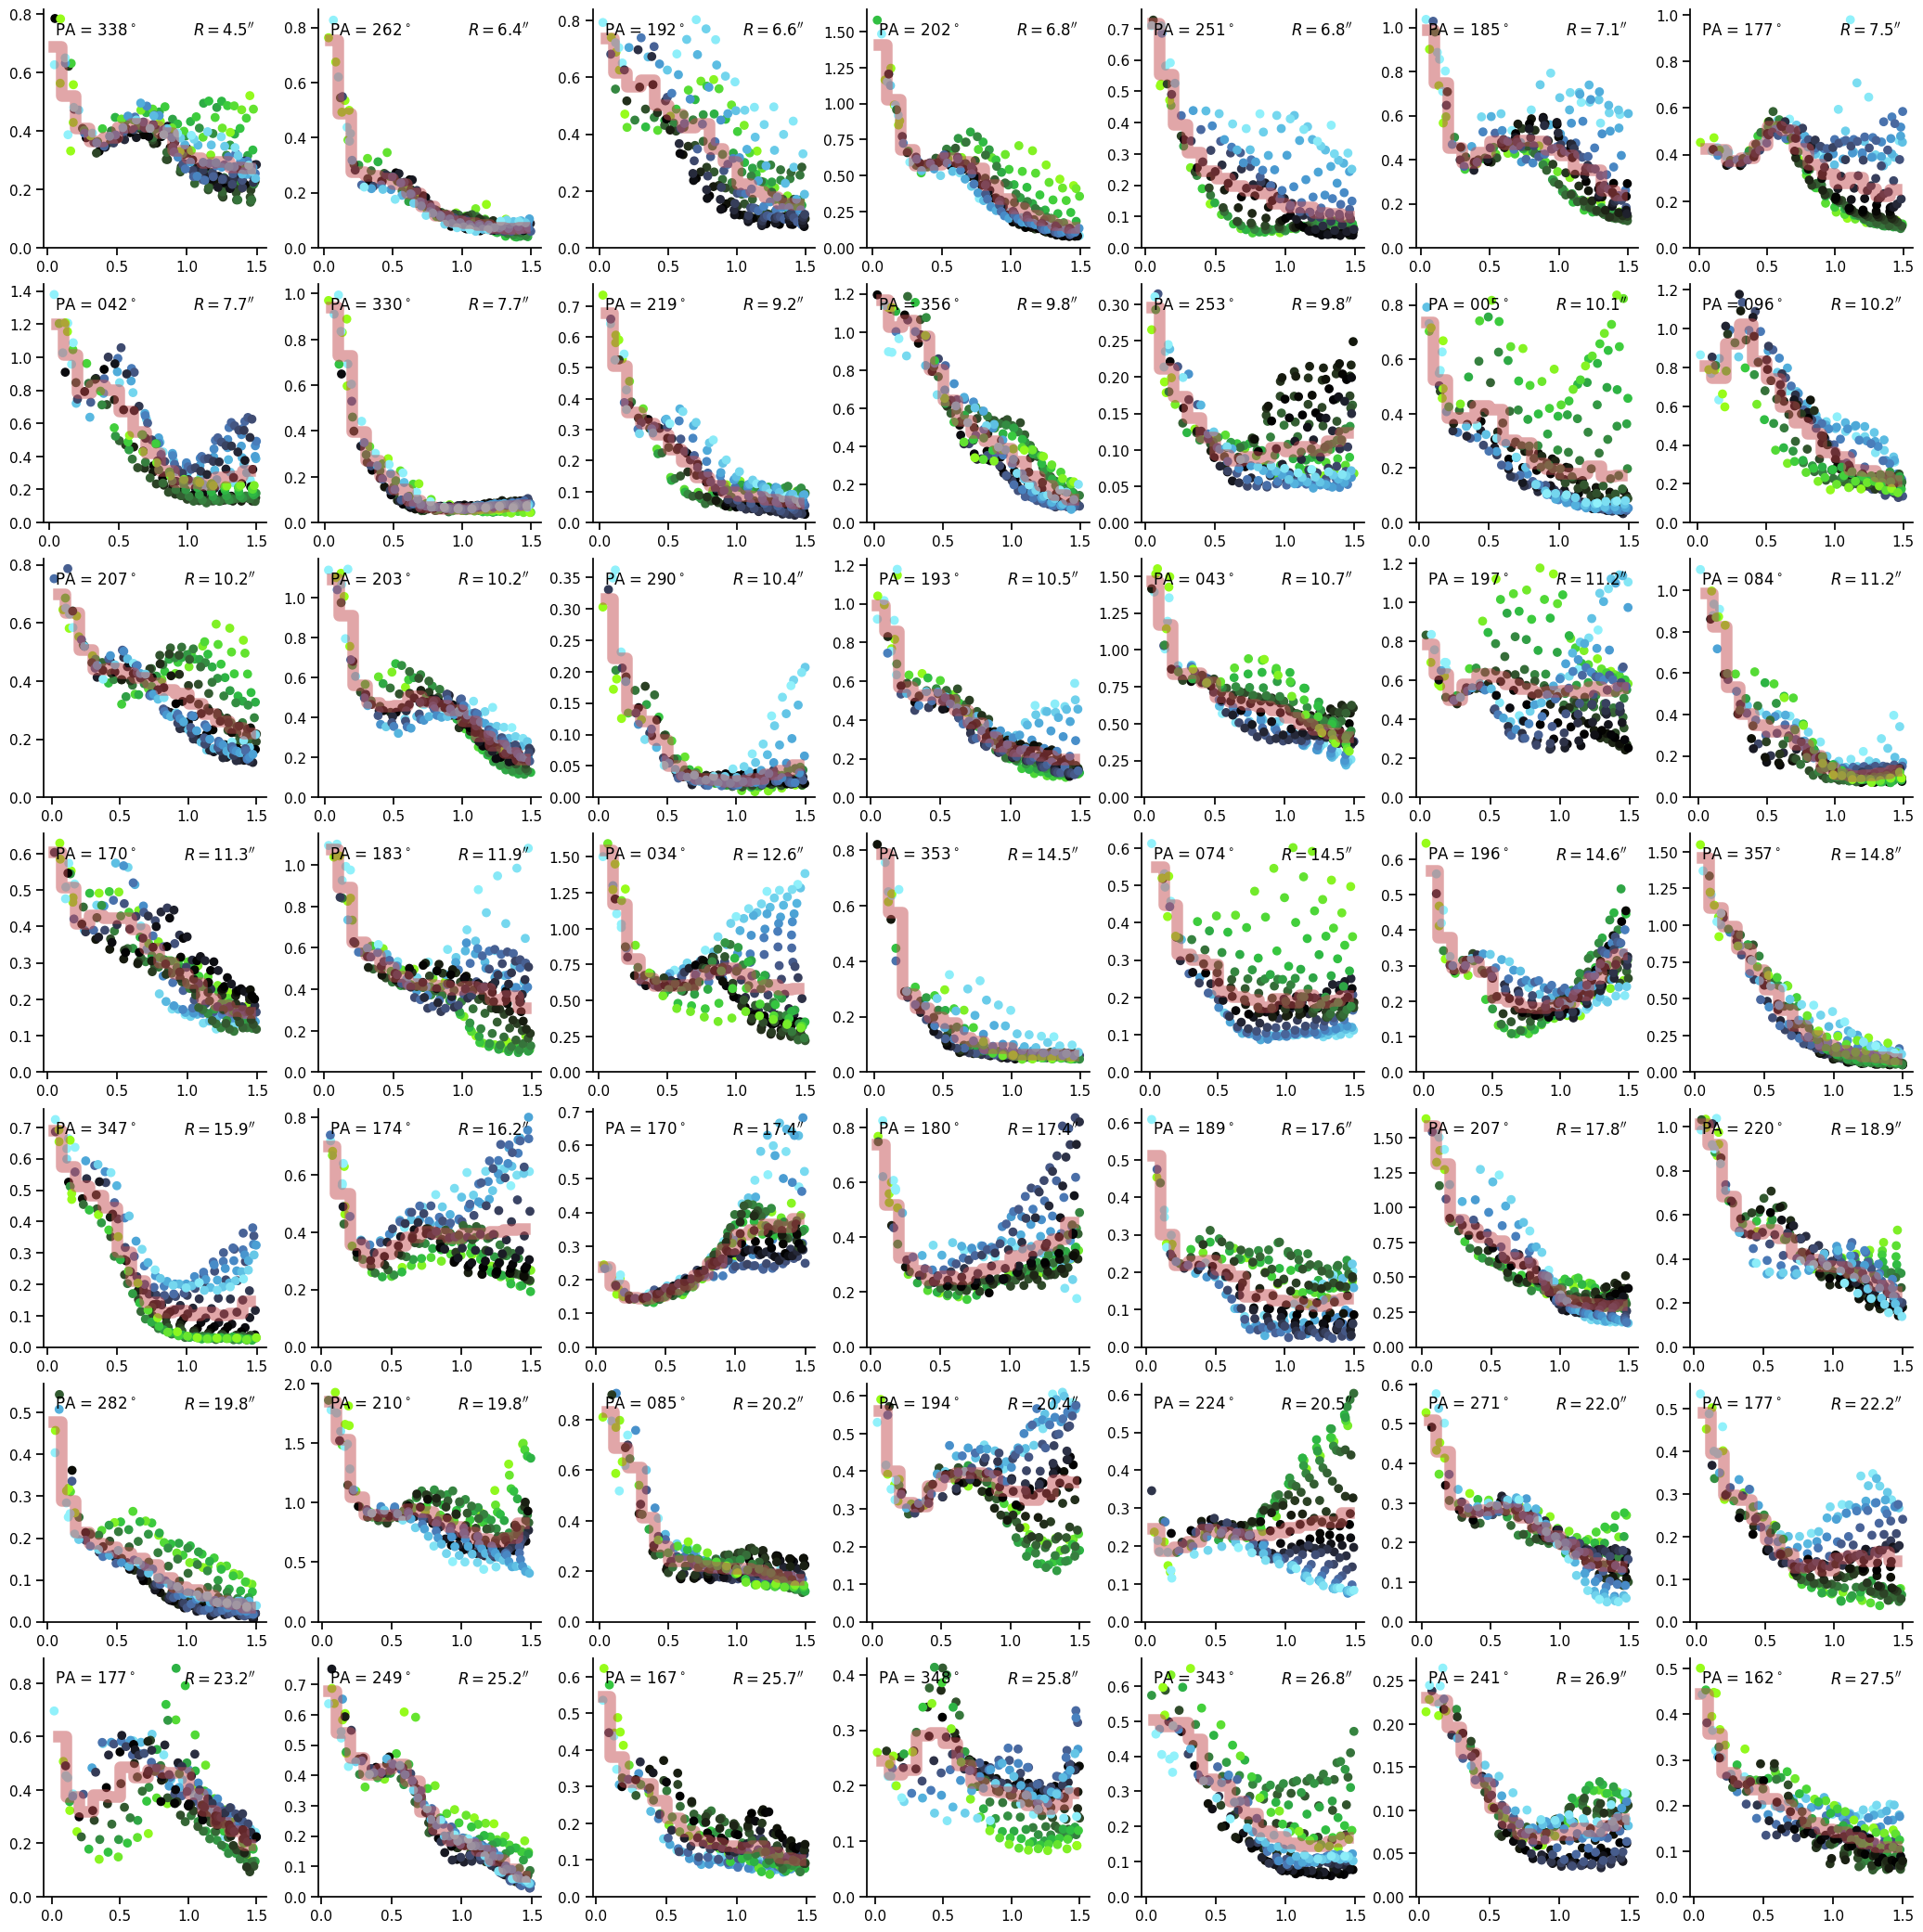

In [49]:
nbins = 15
fig = plt.figure(figsize=(21, 21))
for idx, cutout in enumerate(cutouts):
    ax = fig.add_subplot(7, 7, idx + 1)
    m = cutout.mask
    ax.scatter(
        cutout.r[m].arcsec, 
        cutout.image[m], 
        c=Angle(cutout.pa - cutout.pa_star).wrap_at(180*u.deg).deg[m], 
        vmin=-60, vmax=60,
        cmap=cm.seaweed)
    h1, edges = np.histogram(cutout.r.arcsec[m], range=[0.0, 1.5], bins=nbins, weights=cutout.image[m])
    h0, edges = np.histogram(cutout.r.arcsec[m], range=[0.0, 1.5], bins=nbins)
    rgrid = 0.5 * (edges[1:] + edges[:-1])
    ax.plot(rgrid, h1 / h0, drawstyle="steps-mid", linewidth=9, c='r', alpha=0.5)

    ax.text(0.05, 0.95, rf'PA = {round(cutout.pa_source.value):03d}$^\circ$', transform=ax.transAxes, va="top", ha="left")
    ax.text(0.95, 0.95, rf"$R = {cutout.sep.value:.1f}''$", transform=ax.transAxes, va="top", ha="right")
    ax.set(xlabel="", ylabel="", ylim=[0.0, None])
sn.despine()
fig.tight_layout(h_pad=0.3, w_pad=0.3)
...;

In [50]:
fig.savefig("m1-67-globules-profiles-7x7.pdf")

## Future plans
Maybe in different notebooks

### Do a low-pass filtering and then divide by it to get unsharp masked image


### Classify globules into spatial groups

Either do it by hand, or maybe use gaussian mixtures. 